> 주의!
>
> 컴퓨터가 꺼질 수 있음

# Voting (회귀) 하이퍼파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

from hossam.core import *
from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.regression import *

# 보팅 회귀
from sklearn.ensemble import VotingRegressor

# 회귀모형 클래스
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### #02. 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None

상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX

## #02. 데이터 전처리

[1] 훈련/검증 데이터 분할 및 데이터 표준화

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, 'MEDV', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## #03. 하이퍼파라미터 튜닝

### [1] Voting에 참여시킬 개별 알고리즘 객체 생성

In [4]:
lrg = get_estimator(classname=LinearRegression)
rgr = get_estimator(classname=Ridge)
lsr = get_estimator(classname=Lasso)
knr = get_estimator(classname=KNeighborsRegressor)
dtr = get_estimator(classname=DecisionTreeRegressor)
svr = get_estimator(classname=SVR)
sgdr = get_estimator(classname=SGDRegressor)

lrg, rgr, lsr, knr, dtr, svr, sgdr

(LinearRegression(n_jobs=2),
 Ridge(max_iter=1000, random_state=1000),
 Lasso(random_state=1000),
 KNeighborsRegressor(n_jobs=2),
 DecisionTreeRegressor(random_state=1000),
 SVR(max_iter=1000),
 SGDRegressor(early_stopping=True, random_state=1000))

### [2] 보팅 분류기 생성

In [5]:
vo = VotingRegressor(
    # 결합할 알고리즘의 리스트 (이름, 알고리즘객체) - 이름은 개발자가 마음대로 지정
    #estimators=[('lrg', lrg), ('rgr', rgr), ('lsr', lsr), ('knr', knr), ('dtr', dtr), ('svr', svr), ('sgdr', sgdr)],
    estimators=[('lrg', lrg), ('rgr', rgr), ('lsr', lsr), ('knr', knr), ('dtr', dtr)],
    n_jobs=-1)

# 성능에 자신있는 컴퓨터가 아니면 n_jobs =-1는 쓰지 않는 걸로.


### [3] 모듈을 통한 기본 하이퍼파라미터 가져오기

In [6]:
lr_params = get_hyper_params(classname=LinearRegression, key='lrg')
lr_params

{}

In [7]:
rgr_params = get_hyper_params(classname=Ridge, key='rgr')
rgr_params

{'rgr__alpha': [0.01, 0.1, 1, 10]}

In [8]:
lsr_params = get_hyper_params(classname=Lasso, key='lsr')
lsr_params

{'lsr__alpha': [0.01, 0.1, 1, 10]}

In [9]:
knr_params = get_hyper_params(classname=KNeighborsRegressor, key='knr')
knr_params

{'knr__n_neighbors': array([2, 3, 4, 5]),
 'knr__metric': ['euclidean', 'manhattan']}

In [10]:
dtr_params = get_hyper_params(classname=DecisionTreeRegressor, key='dtr')
dtr_params

{}

In [11]:
svr_params = get_hyper_params(classname=SVR, key='svr')
svr_params

{'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'svr__C': [0.01, 0.1, 1, 10]}

In [12]:
sgdr_params = get_hyper_params(classname=SGDRegressor, key='sgdr')
sgdr_params

{'sgdr__penalty': ['l2', 'l1', 'elasticnet'],
 'sgdr__alpha': [0.001, 0.01, 0.1]}

### [4] Voting용 하이퍼 파라미터로 생성

회귀를 위한 Voting의 경우 soft, hard를 구분하지 않는다.

In [13]:
params = {}
params.update(lr_params)
# params.update(rgr_params)
# params.update(lsr_params)
params.update(knr_params)
# params.update(dtr_params)
#arams.update(svr_params)
#params.update(sgdr_params)

### [5] 하이퍼파라미터 튜닝

In [14]:
rcv = RandomizedSearchCV(
    estimator=vo, 
    param_distributions=params, 
    n_iter=get_max_iter(), 
    n_jobs=get_n_jobs(),
    random_state=get_random_state(), 
    cv=5)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.sort_values(by='mean_test_score', ascending=False)

result_df

,knr__n_neighbors,knr__metric,mean_test_score
0,2,euclidean,0.777977
1,3,euclidean,0.771946
2,4,euclidean,0.765648
3,5,euclidean,0.764975
4,2,manhattan,0.781706
5,3,manhattan,0.778647
6,4,manhattan,0.775021
7,5,manhattan,0.772207


### [6] 성능평가

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |      0.88849 |     0.810215 |
| 평균절대오차(MAE)             |      2.06505 |      2.70113 |
| 평균제곱오차(MSE)             |      9.38446 |      16.1916 |
| 평균오차(RMSE)                |      3.06341 |      4.02388 |
| 평균 절대 백분오차 비율(MAPE) |       10.077 |      15.0451 |
| 평균 비율 오차(MPE)           |     -2.59584 |     -5.93301 |
+-------------------------------+--------------+--------------+

[학습곡선]


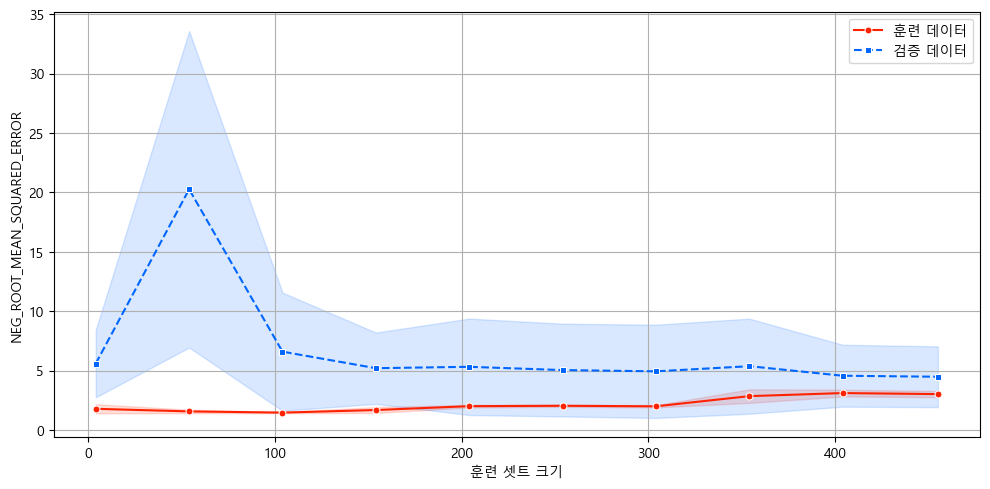

VotingRegressor(estimators=[('lrg', LinearRegression(n_jobs=2)),
                            ('rgr', Ridge(max_iter=1000, random_state=1000)),
                            ('lsr', Lasso(random_state=1000)),
                            ('knr',
                             KNeighborsRegressor(metric='manhattan', n_jobs=2,
                                                 n_neighbors=2)),
                            ('dtr', DecisionTreeRegressor(random_state=1000))],
                n_jobs=-1)

In [15]:
my_regression_result(rcv.best_estimator_, x_train, y_train, x_test, y_test)
rcv.best_estimator_

## #04. 모듈화 기능 확인

[교차검증 TOP5]
+----+--------------------+---------------+-------------------+
|    |   knn__n_neighbors | knn__metric   |   mean_test_score |
|----+--------------------+---------------+-------------------|
|  0 |                  2 | manhattan     |          0.790206 |
|  1 |                  3 | manhattan     |          0.789248 |
|  2 |                  2 | euclidean     |          0.786526 |
|  3 |                  4 | manhattan     |          0.779245 |
|  4 |                  5 | manhattan     |           0.77532 |
+----+--------------------+---------------+-------------------+

[Best Params]
{'knn__n_neighbors': 2, 'knn__metric': 'manhattan'}

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.891001 |      0.74379 |
| 평균절대오차(MAE)             |        2.029 |      2.88767 |
| 평균제곱오차(MSE)             |     

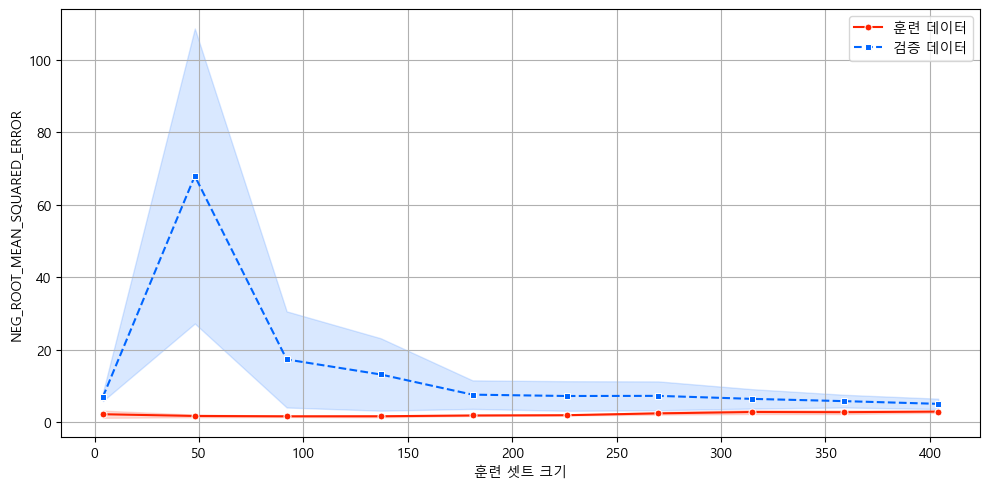


+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 3.31189 |
|  1 | MEDV       | ZN         | 3.19958 |
|  2 | MEDV       | INDUS      | 4.74148 |
|  3 | MEDV       | CHAS       | 1.13018 |
|  4 | MEDV       | NOX        | 6.11484 |
|  5 | MEDV       | RM         | 2.04028 |
|  6 | MEDV       | AGE        | 3.15955 |
|  7 | MEDV       | DIS        | 4.92998 |
|  8 | MEDV       | RAD        | 10.6946 |
|  9 | MEDV       | TAX        | 12.7292 |
| 10 | MEDV       | PTRATIO    | 2.37277 |
| 11 | MEDV       | B          | 1.39447 |
| 12 | MEDV       | LSTAT      | 4.52044 |
+----+------------+------------+---------+



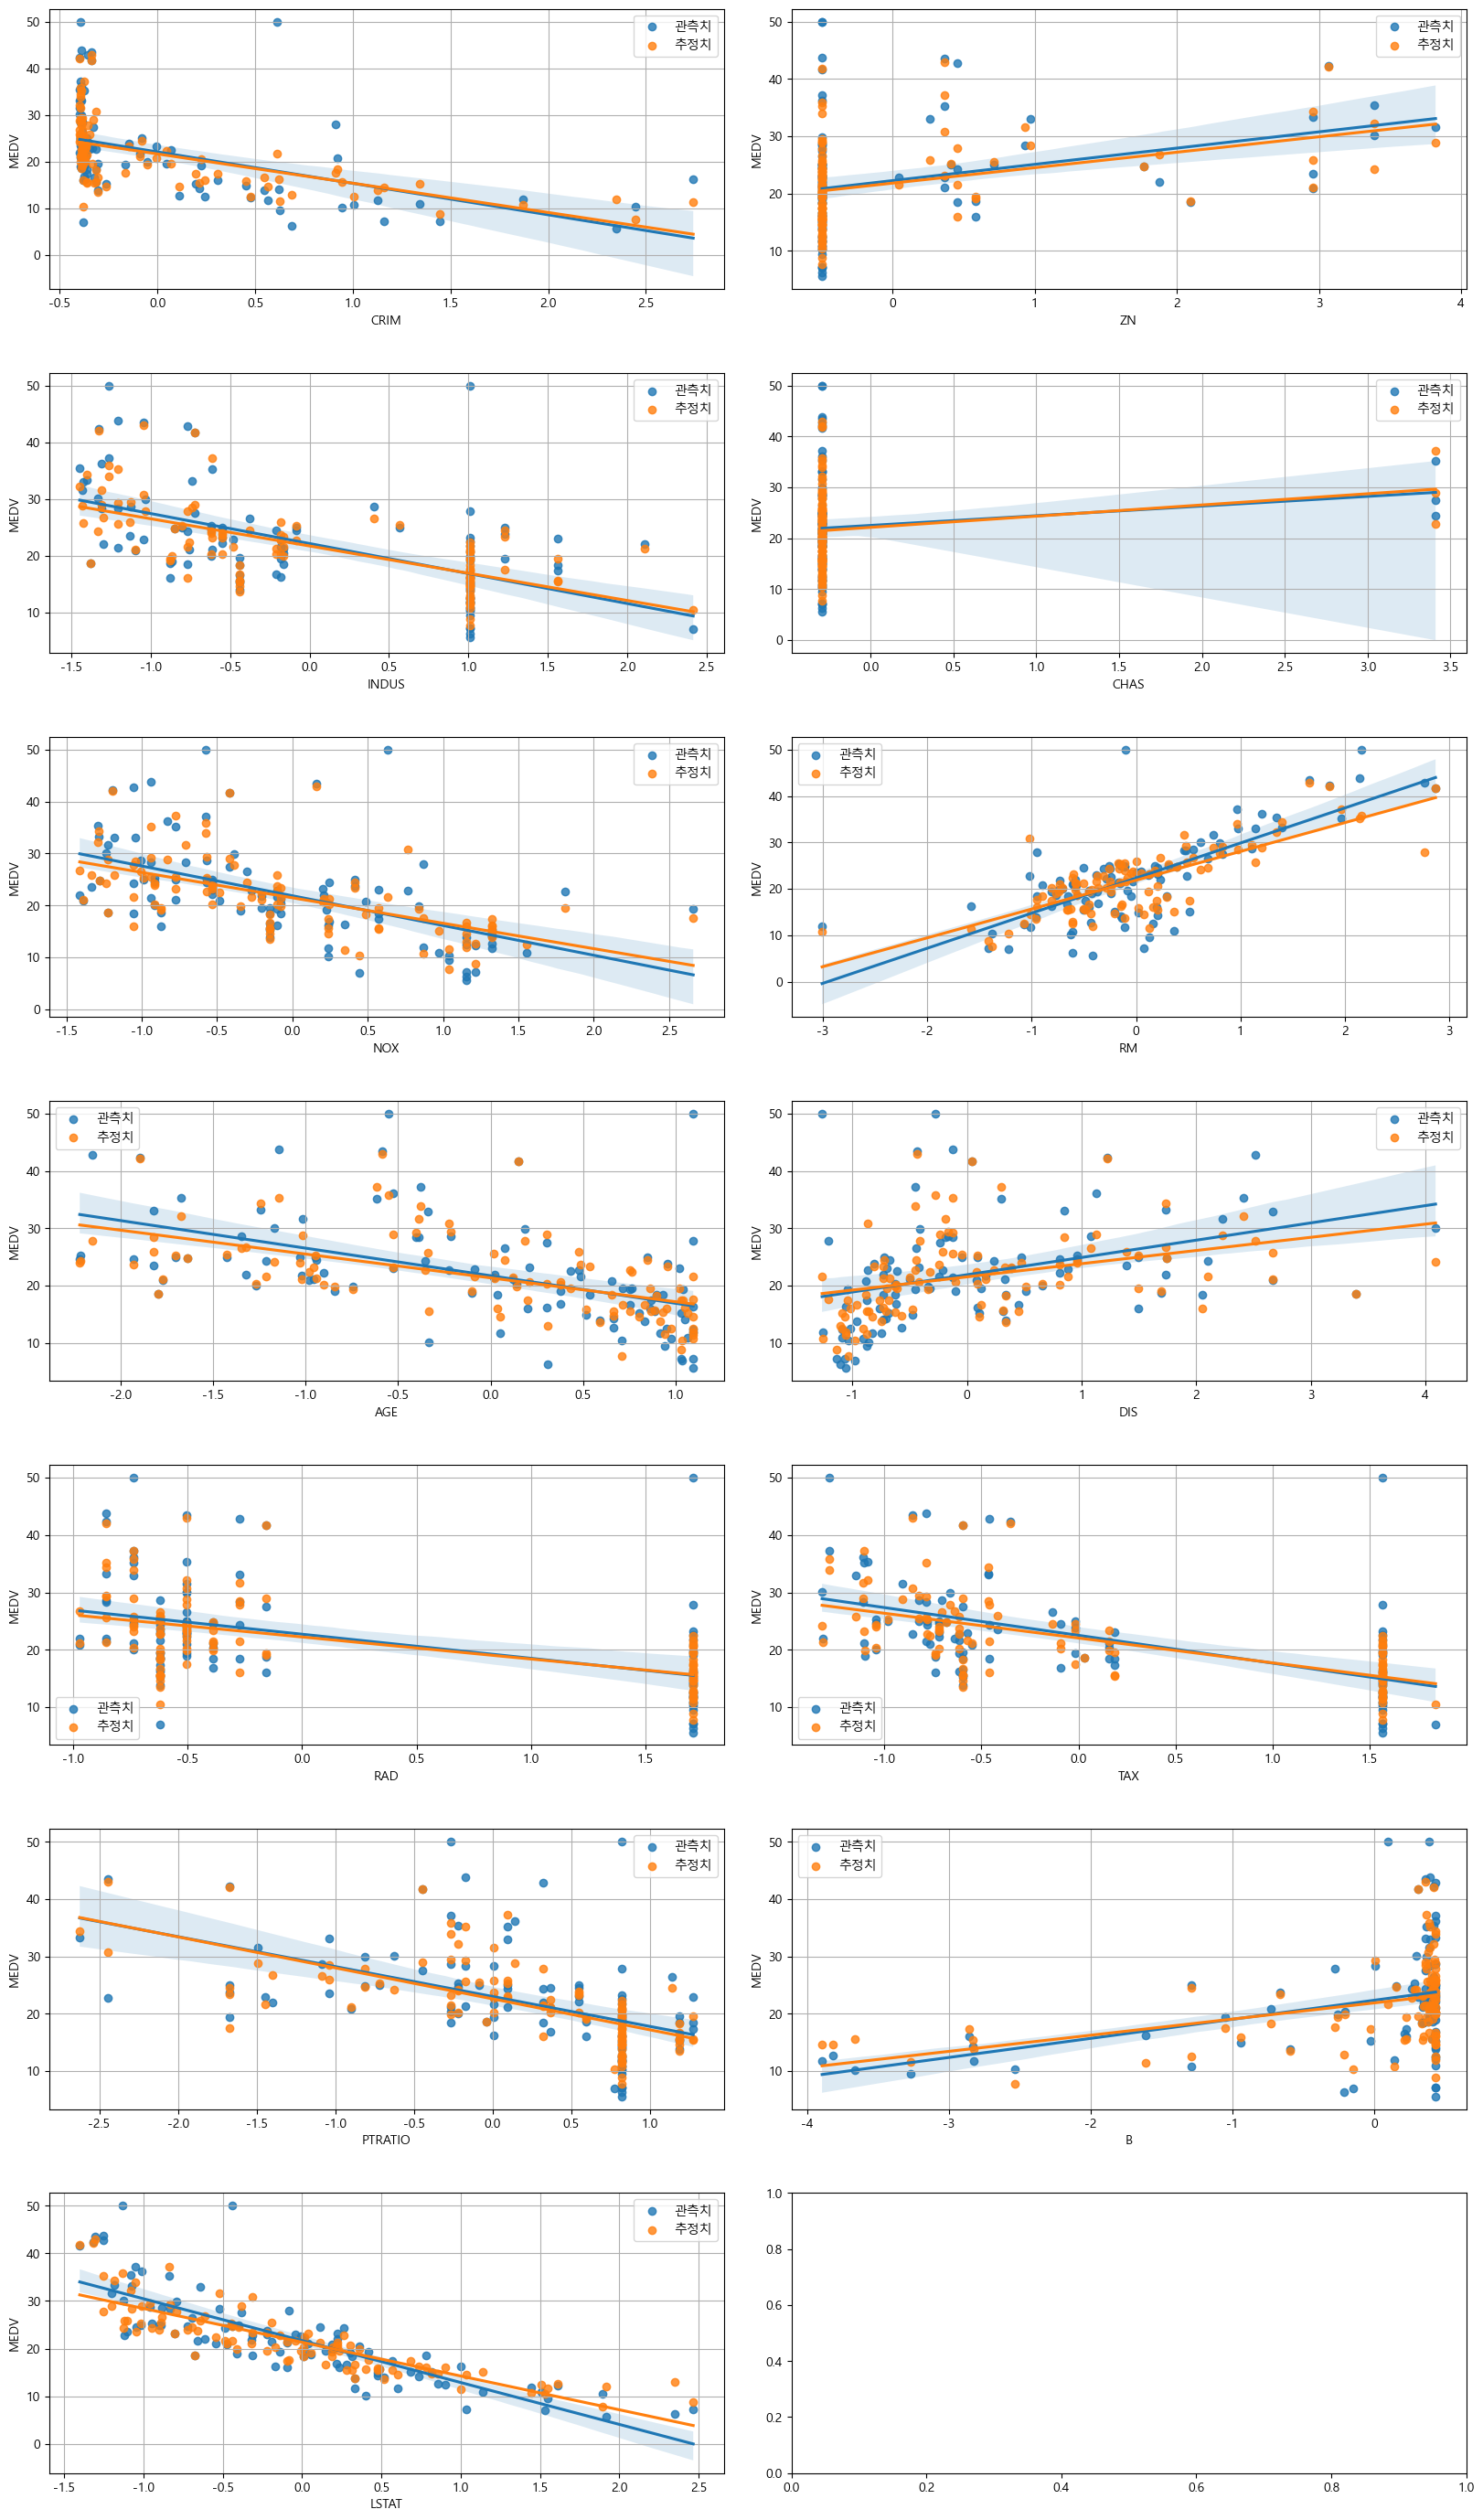

VotingRegressor(estimators=[('lr', LinearRegression(n_jobs=2)),
                            ('knn',
                             KNeighborsRegressor(metric='manhattan', n_jobs=2,
                                                 n_neighbors=2))],
                n_jobs=2)

In [16]:
my_voting_regression(x_train, y_train, x_test, y_test)